# Byte 4: Machine Learning
In this byte you will use machine learning to understand a data set. We will explore the differences in demographics data between males and females. Your goal is to use a combination of exploratory analysis and machine learning to train a model that best predicts the sex of a person (as defined in the US census data) based on their demographics data collected in an anual US census dataset. You will discuss the implications of being able to predict a person's sex and what that means in terms of differences between the sexes (including any biases and discriminations). We will feature models that best predict the sexes in class.

This assignment has two difficulties:

1. beggining programmer, in which you will simply execute the provided code, make small, guided modifications, and interpret the results
2. intermediate to expert programmer, in which you will independently modify the code to add and optimize an algorithm of your choosing.

## Import and Configure Required Libraries
We begin by importing libraries you will use in this byte. We will use Pandas to pre-process and clean the data, Seaborn to visualize the data and perform exploratory analysis, scipy for statistical analysis, and scikit learn (a Python ML library) to train a model that predicts the sex of a person.

In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import metrics

from scipy import stats

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

Custom functions:

In [3]:
# Discritizes columns. Note it changes the order of columns.
def digitize(x, bins=[], cols=[]):
    mask = np.ones(x.shape[1], np.bool)
    mask[cols] = 0
    
    return np.hstack((np.apply_along_axis(np.digitize, 1, x[:,cols], bins=bins), x[:,mask]))

## Dataset: American Community Survey 2015
In this byte we will use data from the 2015 American Community Survey which includes random sample of 3 million people that live in the US. You can find detailed information about the dataset in data/ACS2015_PUMS_README.pdf and a complete data dictionary in data/PUMSDataDict15.txt. We combined the data from the housing and personal files for you, so that each record in the files contains a person record together with their housing record. We also included only persons ages 18 and up. Also note that we have removed some of the variables from the data set.

In this assignment you will experience a machine learning method for selecting and optimizing an algorithm that prevents overfitting and biasing your algorithm on your training data. This helps improve the ability of your model to predict unseen data.

This methodology calls for splitting the data into three different datasets:

1. dev (10% of the data) - optimization set we use for exploratory analysis, feature selection, and algorithm selection and optimization,
2. train (60% of the data) - training data set we use for training our optimized algorithm, and
3. test (30% of the data) - test data set for estimating the final algorithm performance.

At the end of this process you would combine all three datasets back into a single dataset and train your final model on the whole data.

We already split the data for you, although this can easily be done by loading the whole dataset into a Pandas dataframe and using scikit-learn to split it into different parts using the train_test_split() function from the sklearn.model_selection package. The files are:

* data/data.csv.zip - whole dataset
* data/dev.csv.zip - development set
* data/train.csv.zip - training set
* data/test.csv.zip - testing set

Note that we have also taken a part of the original data out that you will not have access to. This holdout set will simulate unseen data for you and we will use it to test your final algorithm.

## Exploratory Analysis and Feature Selection
In this section you will use the development set to explore the data and select your features using a combination of your intuition and statistical methods. Then you will perform a preliminary algorithm selection.

We begin by loading the development set from the data directory. Note that the file is compressed, comma separated values file. We load it into a Pandas dataframe:

In [4]:
dev = pd.read_csv('../data/dev.csv.gz')

Next, read the two documents describing the dataset (data/ACS2015_PUMS_README.pdf and data/PUMSDataDict15.txt) and get familiar with the different variables. You can use Seaborn to visualize the data. For example, you can start with comparing the number of records in the two classes that we will try to predict (1-MALE, 2-FEMALE). Although SEX contains numerical values, it is categorical. Thus, it is important to treat it as such.

<strong>In classification, the class variable is always cathegorical!</strong>

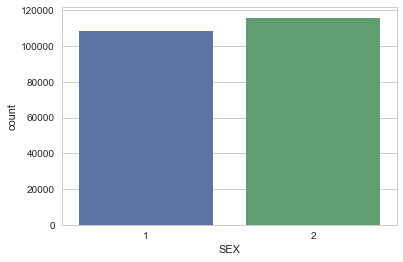

In [5]:
sns.countplot(x="SEX", data=dev)

The count plot above shows that the two classes are fairly balanced. This is good because when classes are NOT balanced, we have to make special considerations when training our algorithms.

### Feature Engineering and Selection
Next, we look for features that might be predictive of the two sexes. Often real world datasets are not clean and require a good understanding of the data before we can apply a machine learning algorithm. Also, data often contains features that are in a format that is not predictive of the class. In such cases training an algorithm on the features without any changes of modification will produce bismal results and the automated feature selection algorithms will not work (if you are in the intermediate to expert stream, we invite you to try to do something like that on this dataset and see what happens).

That is why in this byte we approach this the classification as a feature engineering problem. Here we will explore the data set first and use our intuition, assumptions, and existing knowledge to select a few features that will hopefully help us in the prediction task.

We start off by looking at personal income.

#### Personal Income (PINCP)
We begin by exploring the personal income feature. We hypothesize that females will have lower income than males because of wage inequality (https://en.wikipedia.org/wiki/Gender_pay_gap_in_the_United_States).

Dataset documentation tells us that the feature contains NaN values, but that those values mean that the person is 15 years or younger. That means that the child had no income (the parent or guardian would get the income in this case). That is fine in our case because we only conisder adults, ages 18 and up.

We still impute any possible missing values by replacing them with an income of 0.

In [7]:
dev.loc[dev['PINCP'].isnull(),'PINCP'] = 0
dev.loc[dev['WAGP'].isnull(),'WAGP'] = 0

We then compare the distribution of personal income across the two classes:

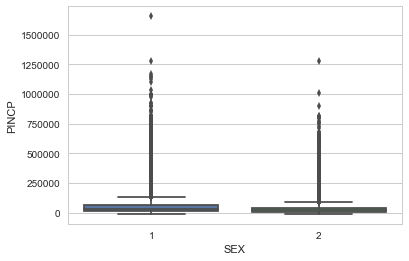

In [14]:
sns.boxplot(data=dev, x='SEX', y='PINCP')

And the distribution of wage income across the two classes.

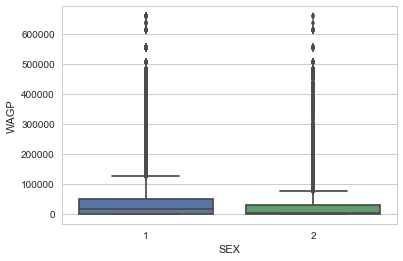

In [15]:
sns.boxplot(data=dev, x='SEX', y='WAGP')

The boxplots shows that there is likely a difference in personal income and wages between the two classes (despite large number of ourliers). We also note that the data is likely not normally distributed, which will come into play later. However, there also does not seem to be a clear (linear) separation between the two classes.

We pause our exploration of personal income to take a look at other features.

#### Age
We look at age because we noted that we will have difficulty classifying children ages 15 and below, so we should probably consider age in our model somehow.

We note and confirm that there should be no missing values, and plot our data again:

In [9]:
len(dev[dev['AGEP'].isnull()])

0

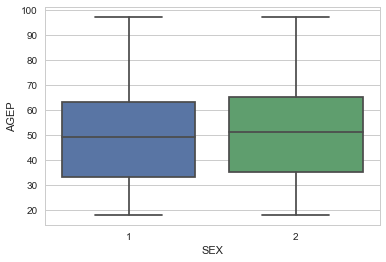

In [10]:
sns.boxplot(data=dev, x='SEX', y='AGEP')

Eyeballing the data, we do not see any major differences between the two sexes. Also, note that although there are differences in the life expectency between the two sexes (https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy), the data reffers to the person's current age, and not their projected life expectancy. We choose not to include age as it is right now.

#### Marital Status
The age discussion above brings up an interesting point: females have higher life expectancy. Thus, we would expect that there would be more widowed females than males. Thus, we search the dataset for a feature that indicates if a person is widowed or not: marital status.

However, unlike the previous two features, this feature is categorical although in the data set it is encoded as a number. <strong>You always have to ensure that features have the right type!</strong>

Because it is categorical, we use count plot to look at it:

In [11]:
len(dev[dev['MAR'].isnull()])

0

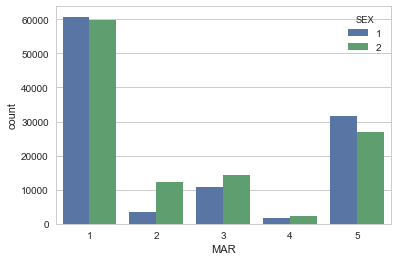

In [12]:
sns.countplot(data=dev, x='MAR', hue='SEX')

Eyeballing the data, it looks like we are correct. However, this feature will only help in a small number of cases when a person is widowed. What else can you see in this chart?

#### Occupation
Gender differences in occupational distribution among workers persist even if occupation is a volountary choice (https://www.bls.gov/opub/mlr/2007/06/art2full.pdf). Thus, we explore each person's occupation as a potential feature.

However, not only is this feature categorical, documentation reveals that there is also a large number of possible values for this feature. This often significantly degrades machine learning algorithm performance because there is usually not enough examples for each value to make accurate inference. 

Since the first two digits of the occupation code represent an occupation class, we can reduce the number of values by grouping everything with the same starting digits together. 

We preserve the old feature for reference, and add a new one. We first convert all values that are not null:

In [16]:
dev['SCOP_REDUCED'] = pd.to_numeric(dev[dev['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))

And then we preserve the special value of NaN in this case (less than 16 years old or never worked) and assign it to a special code '00':

In [17]:
dev.loc[dev['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0

We now look at the difference in occupation across sexes.

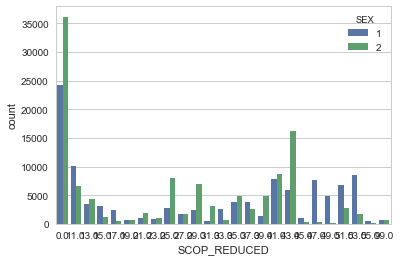

In [15]:
sns.countplot(data=dev, x='SCOP_REDUCED', hue='SEX')

We see that there are still differences between occupation categories between the two sexes (e.g., construction '47' is still dominated by males, but education and administrative is dominated by females).

#### Revisiting Wage Gap
Now we are ready to look at the wage gap again. Our goal is to capture the wage gap (if it exists). We consider three different ways to do this:

1. We could look at the income proportion of the person compared to the total family income.
2. We can compare how far the person's income is from the median or mean salary of males and females.
3. We can compare how far the person's income is from the median or mean salary of males and females in their occupation.

The following barplot shows personal income by occupation and gender, using comparative boxplots (option 3). Can you make a plot for option 1 (gender vs family income) or option 2 (gender vs personal income)? Can you plot the same things for wage instead of income? Ask yourself which of these plots is most informative and why?

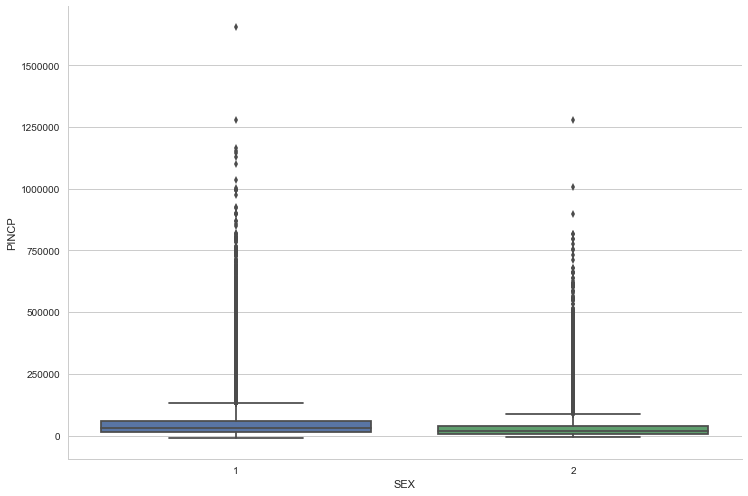

In [19]:
sns.factorplot(data=dev[['SCOP_REDUCED', 'SEX', 'PINCP']], x='SCOP_REDUCED', y='PINCP', hue='SEX', kind='box', size=7, aspect=1.5)


Eyeballing the results, we can conclude that females are on average paid less than males across different occupation fields. Here we decide to include the income and wage features as they are and let the model decide the differences between the classes.

<strong>If you are in the intermediate/expert stream:</strong> try finding other features that also highlight gender gaps and may be predictive of sex. 

#### Your Features
<em>If you are in the intermediate to expert stream, this is where you would explore your own features that could potentially improve the classification performance. Use the examples above to come up with new features. You can reuse some of the features above or completely discard them.</em>

### Feature Summary
Here we finalize a list of features we created and/or selected in the previous step. Below is a list of features we will use. Remember to add your own features if you selected and/or created any.

In [20]:
# Modify this cell to add more features if any.
select_features = ['PINCP', 'WAGP', 'MAR', 'SCOP_REDUCED']
categorical_features = ['MAR', 'SCOP_REDUCED']

# Used for specifying which features to bin in $20,000 increments.
# Note that if you have features you would like to bin in a custom way, then you will have to modify the Naive Bayes
# classifier below.
monetary_features = ['PINCP', 'WAGP']

We will now create a new dev data frame containing only the selected features and the class.

In [21]:
select_dev = dev[select_features + ['SEX']]

### Questions you need to answer:
<strong>Both paths:</strong> <em>Summarize your findings about different features you selected, including insights about why they should help you predict/classify males and females.</em>

## Algorithm Selection and Optimization
In this section we will use the features we selected above to train and evaluate different machine leaning algorithms. Often it is not immediately clear which algorithm will perform the best on the dataset. Even if we are certain that an algorithm will do well, we need to compare it with a baseline algorithm (e.g., Zero R, which always selects the majority class) to make sure that we are improving on the status quo.

We will compare a few algorithms to find out which one is most promissing. We perform this selection on the development set so that we do not overfit on the training data (which would have effects on the performance of the algorithm on unseen data). Because our development set is comparably small, we will use cross-validation to evaluate our algorithms. However, because we also want to optimize the algorithms we are comparing (to ensure we are selecting the best configuration) we will use what we call inner-outer 10 fold cross validation.

In the inner fold we will optimize an algorithm and pick the best optimization, and in the outerfold we will compare the best opimized algorithms.

In most cases we desire an algorithm with a high accuracy as a score. This metric is a decent indicator of performance when classifying balanced classes (as is our case). However, sometimes it is even more important to consider the impact of errors on the performance (precision and recall) and the general quality of the fit (kappa statistic).

We begin by defining a set of algorithms that we will compare. We chose 3 algorithms:

1. Zero R, which always picks the majority class. This is our baseline.
2. Naive Bayes, which is a fast algorithm and is based on the Bayes' theorem, but with a naive assumptions about independence of features given the class (http://scikit-learn.org/stable/modules/naive_bayes.html)
3. Decision Tree, which is a non-parametric supervised learning method used for classification that predicts the value of a target variable by learning simple decision rules inferred from the data features (copied from http://scikit-learn.org/stable/modules/tree.html).

<strong>If you are in the intermediate/expert path you need to pick your own algorithm to add to the race!</strong> If you are unsure where to start, you can use this chart to help you pick an algorithm: http://scikit-learn.org/stable/tutorial/machine_learning_map/. Then add specifications for your algorithm below (use the existing examples on how to create your own pipeline for the algorithm):

In [22]:
classifiers = {}
classifier_parameters = {}

# Zero R
# This classifier does not require any additional preprocessing of data.
classifiers['ZeroR'] = DummyClassifier(strategy='prior')

# Binomial NB classifier
# This classifier requires that all features are in binary form.
# We can easily transform categorical data into binary form, but we have to first disretize continius variables first.
classifiers['Naive Bayes'] = Pipeline([
    ('discretize', FunctionTransformer(func=digitize, kw_args={'bins':np.array([0.0, 20000.0, 40000.0, 80000.0, 100000.0]), 'cols':pd.Series(select_features).isin(monetary_features)})), 
    ('tranform', OneHotEncoder(categorical_features='all')), 
    ('clf', BernoulliNB())])

# Decision Tree classifier
# This classifier can work on continious features and can find a good separation point on its own.
# We still have to convert categorical data to binary format.
classifiers['Decision Tree'] = Pipeline([('tranform', OneHotEncoder(categorical_features=pd.Series(select_features).isin(categorical_features))), ('clf', DecisionTreeClassifier())])

# Maximum Depth for a decision tree controls how many levels deep the tree will go before it stops.
# More levels means less generalizability, but fewer levels means less predictive power.
classifier_parameters['Decision Tree'] = {'clf__max_depth':(1, 3, 9, 12)}


We prepare out development set by creating 10 folds we will use to evaluate the algorithms.

We now iterate over the classifiers and report the metrics for all of them. Sklearn offers a number of functions to quickly score results of a cross validation, but we would like to make sure that all of the algorightms run on the same folds. So we quickly code our own experiment below. Note that this will take some time to run, so don't rush past it until it stops producing output.

In [36]:
# Create a label encoder to transform 1-MALE, 2-FEMALE into classes that sklearn can use (0 and 1).
le = LabelEncoder() 

# Split features and class into two dataframes.
X_dev = select_dev.ix[:, select_dev.columns != 'SEX'].values
y_dev = le.fit_transform(select_dev['SEX'].values)

kf = KFold(n_splits=10, shuffle=True)

# Initialize scores dict
scores = pd.DataFrame(columns=['fold', 'algorithm', 'parameters', 'accuracy', 'precision', 'recall'])

# For each fold run the classifier (outer CV).
fold = 0
for train_index, test_index in kf.split(X_dev):
    X_train, X_test = X_dev[train_index], X_dev[test_index]
    y_train, y_test = y_dev[train_index], y_dev[test_index]
    
    fold = fold + 1

    # Iterate over classifiers
    for name, clf in classifiers.items():
        # If the classifier has parameters, then run inner CV.
        # Luckily sklearn provides a quick method to do this.
        if name in classifier_parameters:
            gs = GridSearchCV(estimator=clf, param_grid=classifier_parameters[name])
            gs.fit(X_train, y_train)
            y_pred = gs.predict(X_test)
            best_params = str(gs.best_params_)
        else:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            best_params = 'default'
        
        scores = scores.append(pd.DataFrame(data={'fold':[fold],
                                                  'algorithm':[name], 
                                                  'parameters':[best_params], 
                                                  'accuracy':[accuracy_score(y_test, y_pred)], 
                                                  'precision':[precision_score(y_test, y_pred)],
                                                  'recall':[recall_score(y_test, y_pred)]}), 
                               ignore_index=True)
        

/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/jmankoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolea

### Selecting the Best Algorithm
Here we analyze the results of our experiment and compare the algorithm scores to find the best algorithm. The sumary and box plot below shows the accuracy of the best algorithms in the outer fold. See if you can also plot the precision and recall to better understand your results. Do you see anything unusual? Can you explain it?

In [38]:
scores[['algorithm', 'accuracy', 'precision', 'recall']].groupby(['algorithm']).median()

,accuracy,precision,recall
algorithm,,,
Decision Tree,0.710624,0.733104,0.699249
Naive Bayes,0.646205,0.642760,0.711039
ZeroR,0.517310,0.517310,1.000000


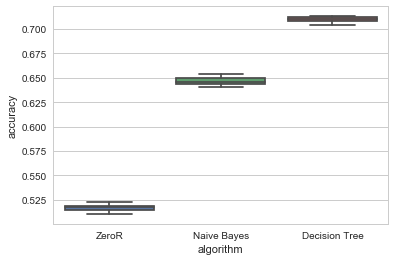

In [42]:
sns.boxplot(data=scores, x='algorithm', y='accuracy')

From the boxplots we can see that the Decision Tree was the best. That said, the accuracy of the decision tree is still pretty low at .71 (71%). 

#### Running Statistical Tests
We now run a statistical test on the accuracies across different algorithms to ensure that the results above did not happen by chance. We ensured that we trained and evalueted all of the algorithms on the same outer folds, which means that we need to run a pairwise comparison. Also, although eyeballing the boxplot above we could assume that the accuracies came from normal distribution, we know that accuracy is takes value on an interval from [0,1] so we choose a non-parametric test instead (Friedman test, https://en.wikipedia.org/wiki/Friedman_test). We will perform post-hoc pairwise comparison using a Wilcoxon test.

Our null-hypothesis is that there is no difference between the algorithms.

In [24]:
matrix = scores.pivot(index='fold', columns='algorithm', values='accuracy').as_matrix()
stats.friedmanchisquare(matrix[:,0], matrix[:,1], matrix[:,2])

FriedmanchisquareResult(statistic=20.0, pvalue=4.5399929762484861e-05)

In [25]:
for i in range(np.shape(matrix)[1]):
    for j in range(i+1, np.shape(matrix)[1]):
        print(stats.wilcoxon(matrix[:,i], matrix[:,j], correction=True))

WilcoxonResult(statistic=0.0, pvalue=0.0059215370241487084)
WilcoxonResult(statistic=0.0, pvalue=0.0059215370241487084)
WilcoxonResult(statistic=0.0, pvalue=0.0059215370241487084)


The results reject the null hypothesis (because the p values are small, <.005), meaning that we have some confidence there is a repeatable, real difference beteen the algorithms (even if the accuracy is low).

The Decision Tree classifier is unique in the sense that it is easy to visualize the decisions that it is making. Here we look at the top 3 levels of the best algorithm we trained on the whole development set (if you have graph viz installed on your machine):

In [43]:
features = select_dev.columns.tolist()
features = features[1:len(features)-1]

le = LabelEncoder() 

# Split features and class into two dataframes.
X_dev = select_dev.ix[:, select_dev.columns != 'SEX']
y_dev = le.fit_transform(select_dev['SEX'].values)

X_dev_long = pd.get_dummies(data=X_dev, columns=categorical_features)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_dev_long, y_dev)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

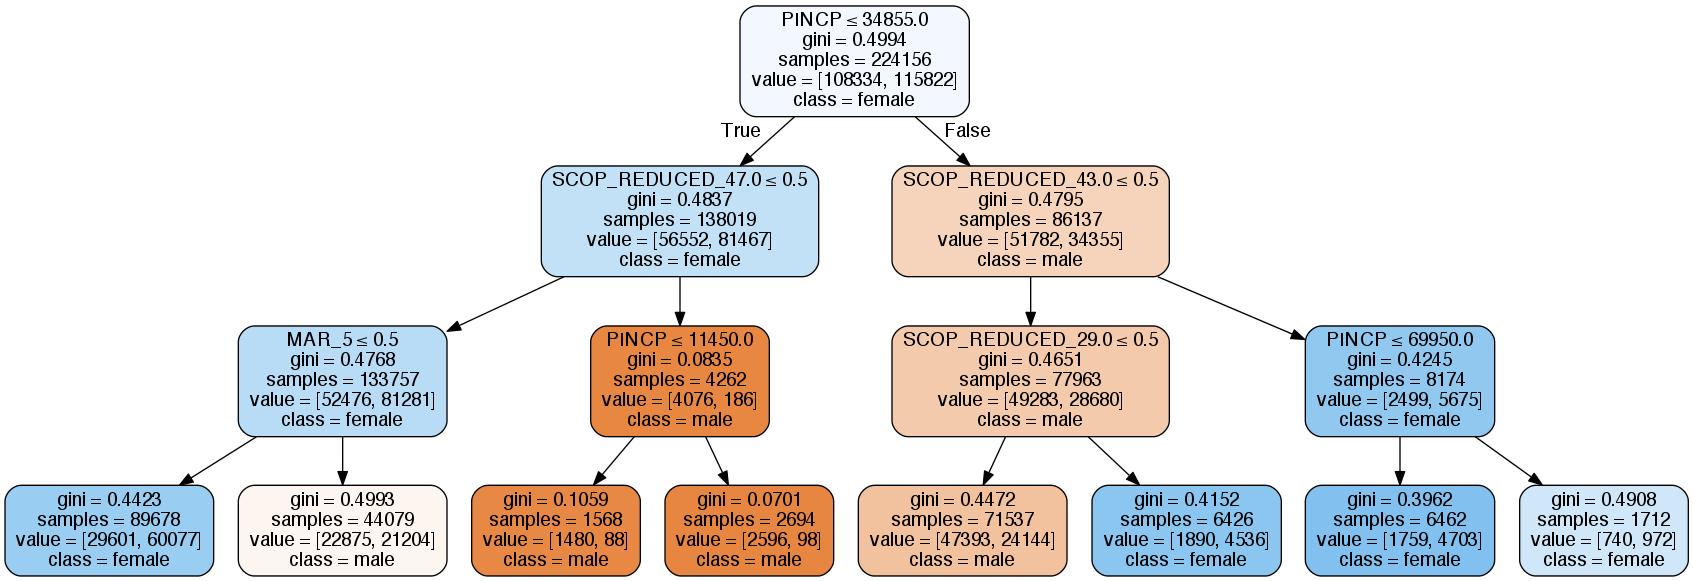

In [27]:
import pydotplus
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=X_dev_long.columns,
                           class_names=['male', 'female'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

#### Questions you need to answer:
What do the results of the tests mean? What can we conclude from the analysis? Is the best algorithm making reasnoble decisions? What kind of errors is the best algorithm making and can we improve somehow?

## Training a Machine Learning Algorithm
In this section, we will use the insights from our exploratory analysis and optimization to train and test our final algorithm. As an illustration, we will use a DecisionTreeClassifier with maximum depth of 12 because this algorithm performed the best in the development phase. We are going to use the training data set to train the algorithm and the test data set to test it. In this phase we should have enough data to accurately estimate the performance of the algorithm, so we do not need to use cross validation.

<strong>If you are in the intermediate/expert stream: </strong> if you changed or added any features of if your algorithm performed the best in the development stage, then make sure you make appropriate changes to both the features and algorithm.

### Data pre-processing
Here we load and pre-process the data in exactly the same way as we did above (which means if you make any changes to features or algorithms above, you will need to copy them down here too). You can try plotting this data to make see if it looks about the same as our dev set (it should). 

In [ ]:
train = pd.read_csv('../data/train.csv.gz')
test = pd.read_csv('../data/test.csv.gz')

##### Marriage

In [ ]:
# Ensure there is no NaN values.
print(len(train[train['MAR'].isnull()]))
print(len(test[test['MAR'].isnull()]))

#### Occupation

In [51]:
# Reduce and make sure no NaN.
train['SCOP_REDUCED'] = pd.to_numeric(train[train['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))
train.loc[train['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0
test['SCOP_REDUCED'] = pd.to_numeric(test[test['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))
test.loc[test['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0

#### Income and Wages

In [52]:
train.loc[train['PINCP'].isnull(),'PINCP'] = 0
train.loc[train['WAGP'].isnull(),'WAGP'] = 0
test.loc[test['PINCP'].isnull(),'PINCP'] = 0
test.loc[test['WAGP'].isnull(),'WAGP'] = 0

### Train the Best Algorithm
Now we train the best algorithm using the training data set (the pre-processed features) and the specifications about the best algorithm.

In [53]:
select_train = train[select_features + ['SEX']]
select_test = test[select_features + ['SEX']]

We use the same pipeline as we did in the development stage, except that we only use one set of parameters (in this case max_depth=12). 

In [54]:
# Decision Tree classifier
# This classifier can work on continious features and can find a good separation point on its own.
# We still have to convert categorical data to binary format.
best_clf = Pipeline([('tranform', OneHotEncoder(categorical_features=pd.Series(select_features).isin(categorical_features))), ('clf', DecisionTreeClassifier(max_depth=12))])

In [55]:
# Split features and class into two dataframes.
X_train = select_train.ix[:, select_train.columns != 'SEX'].values
y_train = le.fit_transform(select_train['SEX'].values)

X_test = select_test.ix[:, select_test.columns != 'SEX'].values
y_test = le.fit_transform(select_test['SEX'].values)

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
y_score = best_clf.predict_proba(X_test)

### Evaluate the Best Algorithm
We now calculate a series of statistics that allow us to gauge how well the algorithm will perform on unseen data.

In [58]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.712155813262
             precision    recall  f1-score   support

          0       0.69      0.73      0.71    323513
          1       0.74      0.69      0.71    349087

avg / total       0.71      0.71      0.71    672600



#### ROC Curve
Now we plot the ROC curve that tells us how well our algorithm detected true positives vs. false positives (from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

In [59]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)

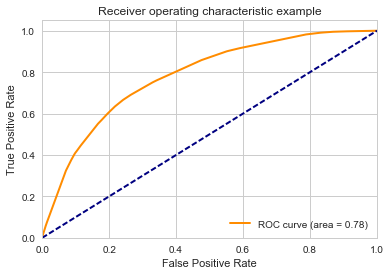

In [60]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Any curve above the blue line means that the algorithm is predicting better than by random chance. However, we would ideally like to have the orange curve as close as possible to the y-axis and ROC curve area to be in the .90's.

#### Intermediate/expert stream: Precision/Recall Curve


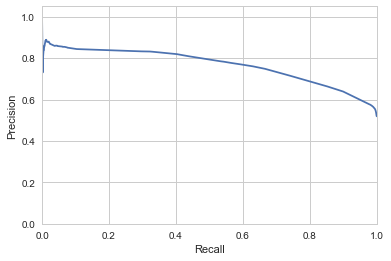

In [38]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score[:,1])
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

The Precision/Recall Curve is not impressive either. Ideally, a rule of thumb tells us that a good model would have a curve that crosses (Precision, Recall) at (90, 80).

We can now take a quick glance at the errors and if there is anything else we could have done better in hindsight. The code below selects all records where the algorithm awas wrond on the test set. What insights can you make from that? (hint: use the same feature visualization techniques we used when selecting features). Note that we should do this with the dev set. Thus we quickly test on it before visualizing this. Ideally we would use a classifier also trained no the dev set, instead of best_clf. This is left as an exercise to the reader.

<strong>Intermediate/expert stream:</strong> Use the precision/recall and ROC curves to evaluate your feature engineering and algorithm selection, not just NSHT (but remember to focus on your dev set). Has your algorithm come close to .9 under the curve? Can you design a model (using your dev set) that has high performance on this ROC and precision/recall curves? How can you use explorations of errors such as the one illustrated below to improve your algorithms?

In [65]:
select_test = dev[select_features + ['SEX']]
X_test = select_test.ix[:, select_test.columns != 'SEX'].values
y_test = le.fit_transform(select_test['SEX'].values)
y_pred = best_clf.predict(X_test)
y_score = best_clf.predict_proba(X_test)

dev_wrong = dev[y_pred != y_test]

For example, the example below shows the distribution of different values of marriage feature .

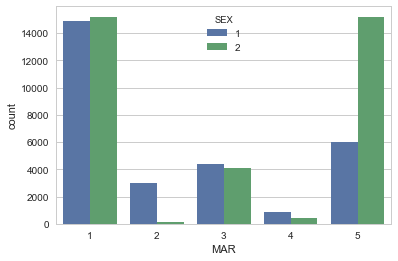

In [66]:
sns.countplot(data=dev_wrong, x='MAR', hue='SEX')

### Questions you need to answer:
<strong>Both streams:</strong> Discuss the performance of the best algorithm and how you think it can be further improved. What kind of errors is the algorithm still making at this point in your ipython notebook?